# Projet Portfolio Data Analyst : Analyse Bitcoin & Ethereum
#### Objectif : Étudier l’évolution de Bitcoin et Ethereum depuis leur création, analyser leur comportement (prix, volatilité, corrélation), et produire une projection à moyen terme (3-5 ans) à l'aide d'un modèle prédictif simple.


# Import des libraries

In [ ]:
!pip install yfinance --upgrade

In [ ]:
!pip install plotly

In [ ]:
!pip install prophet

In [2]:
# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des données financières
import yfinance as yf
print(yf.__version__)

# Travail sur les dates
from datetime import datetime

# Modélisation prédictive (Prophet)
from prophet import Prophet

# Pour ignorer les warnings pendant l'exécution
import warnings
warnings.filterwarnings('ignore')

0.2.63


# Collecte des données (webscraping)

In [3]:
# Définir la période d'étude
start_date = '2014-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Télécharger les données séparément (très important ici)
btc = yf.download('BTC-USD', start=start_date, end=end_date, group_by='ticker')
eth = yf.download('ETH-USD', start=start_date, end=end_date, group_by='ticker')

# Vérifier la structure de données
print(btc.head())
print(eth.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Ticker         BTC-USD                                              
Price             Open        High         Low       Close    Volume
Date                                                                
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100
Ticker         ETH-USD                                                
Price             Open        High         Low       Close      Volume
Date                                                                  
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992
2017-11-12  314.690002

In [4]:
# On écrase le multi-index éventuel des colonnes
btc.columns = btc.columns.get_level_values(-1)
eth.columns = eth.columns.get_level_values(-1)

# Vérification
print(btc.columns)
print(eth.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')


# Préparation et nettoyage des données

In [5]:
# Supprimer les valeurs manquantes
btc.dropna(inplace=True)
eth.dropna(inplace=True)

# Synchroniser les dates communes
common_dates = btc.index.intersection(eth.index)
btc = btc.loc[common_dates]
eth = eth.loc[common_dates]

In [6]:
# Extraction des colonnes 'Close'
btc_close = btc['Close']
btc_close.name = 'BTC_Close'

eth_close = eth['Close']
eth_close.name = 'ETH_Close'

# Fusion propre
df = pd.concat([btc_close, eth_close], axis=1)

# Vérification finale
print(df.head())
print(df.columns)

              BTC_Close   ETH_Close
Date                               
2017-11-09  7143.580078  320.884003
2017-11-10  6618.140137  299.252991
2017-11-11  6357.600098  314.681000
2017-11-12  5950.069824  307.907990
2017-11-13  6559.490234  316.716003
Index(['BTC_Close', 'ETH_Close'], dtype='object')


# Analyse Exploratoire

### Evolution des prix

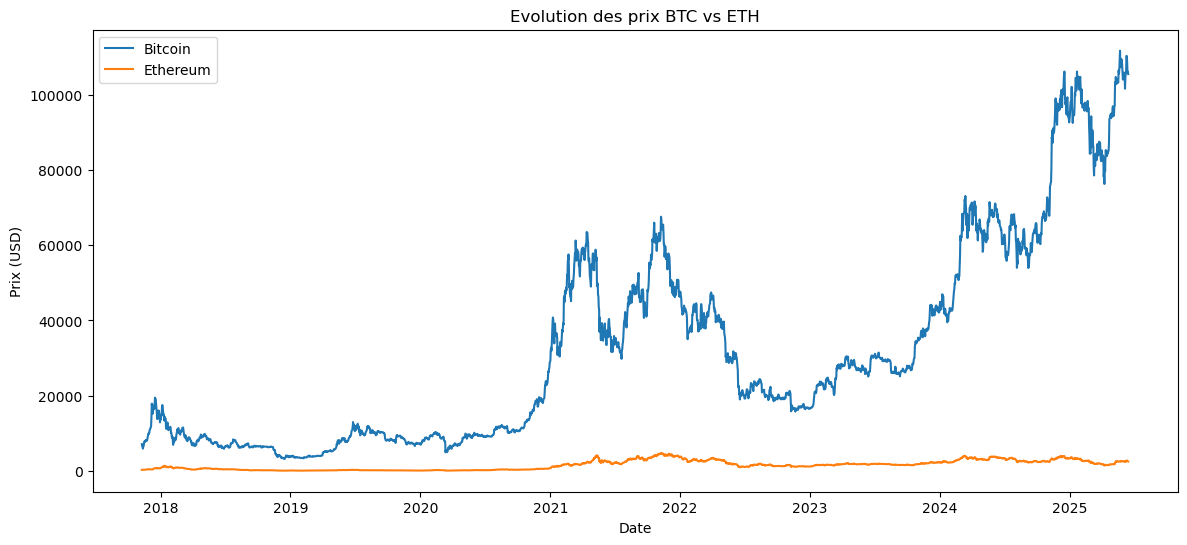

In [7]:
# On définit la taille de la figure
plt.figure(figsize=(14, 6))

# On trace la courbe de Bitcoin (prix de clôture)
plt.plot(df.index, df['BTC_Close'], label='Bitcoin')

# On trace la courbe d'Ethereum (prix de clôture)
plt.plot(df.index, df['ETH_Close'], label='Ethereum')

# Titre du graphique
plt.title("Evolution des prix BTC vs ETH")

# Nom de l'axe des X (les dates)
plt.xlabel("Date")

# Nom de l'axe des Y (les prix en USD)
plt.ylabel("Prix (USD)")

# Afficher la légende (Bitcoin et Ethereum)
plt.legend()

# Afficher le graphique
plt.show()

# Volatilité

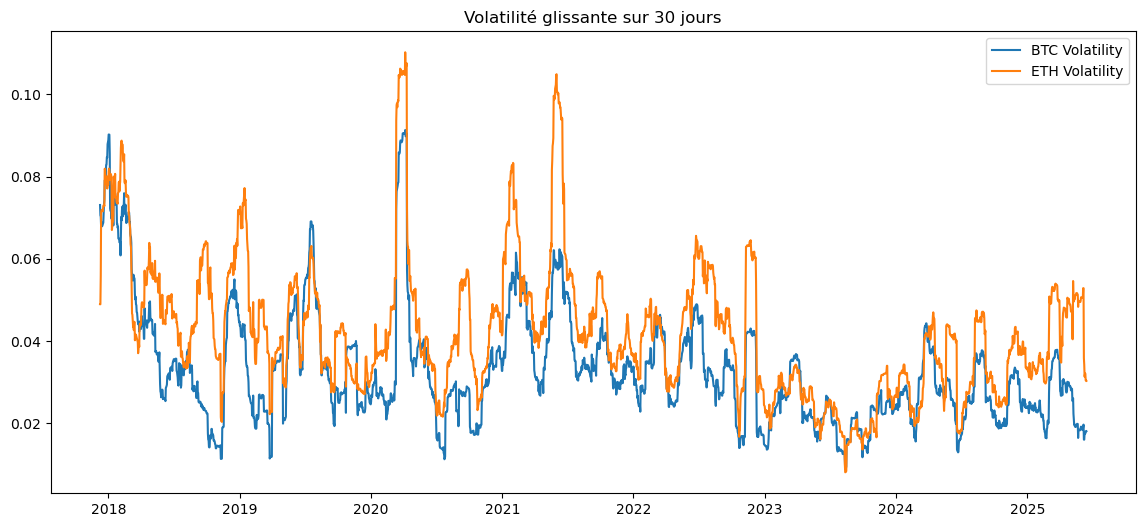

In [8]:
# Calcul de la volatilité sur 30 jours (écart-type des rendements quotidiens)
# pct_change() calcule le rendement quotidien
# rolling(30).std() calcule l'écart-type glissant sur 30 jours

df['BTC_volatility'] = df['BTC_Close'].pct_change().rolling(30).std()
df['ETH_volatility'] = df['ETH_Close'].pct_change().rolling(30).std()

# Tracer les volatilités
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['BTC_volatility'], label='BTC Volatility')
plt.plot(df.index, df['ETH_volatility'], label='ETH Volatility')

plt.title("Volatilité glissante sur 30 jours")
plt.legend()
plt.show()

# Drawdown (les grosses pertes maximales depuis un plus haut historique)

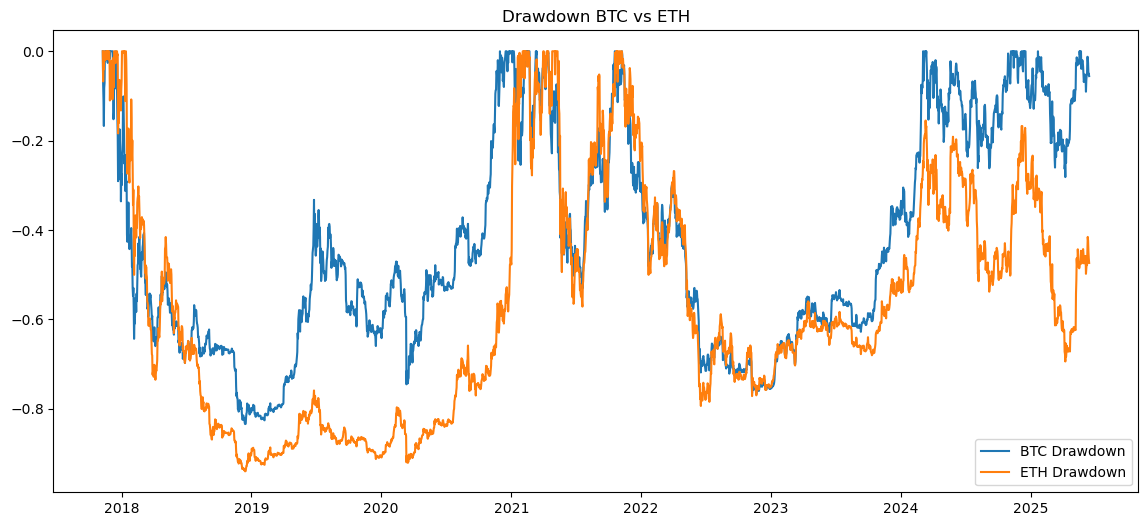

In [9]:
# Fonction pour calculer le drawdown d'une série de prix
def compute_drawdown(series):
    running_max = series.cummax()  # on calcule les plus hauts atteints historiquement
    drawdown = (series - running_max) / running_max  # on calcule la baisse relative depuis ces plus hauts
    return drawdown

# Calcul du drawdown pour Bitcoin et Ethereum
df['BTC_drawdown'] = compute_drawdown(df['BTC_Close'])
df['ETH_drawdown'] = compute_drawdown(df['ETH_Close'])

# Tracer les drawdowns
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['BTC_drawdown'], label='BTC Drawdown')
plt.plot(df.index, df['ETH_drawdown'], label='ETH Drawdown')
plt.title("Drawdown BTC vs ETH")
plt.legend()
plt.show()

# Corrélation entre les 2 cryptos

In [10]:
# Calcul de la corrélation de Pearson entre Bitcoin et Ethereum
correlation = df['BTC_Close'].corr(df['ETH_Close'])

# Affichage du résultat
print(f"Corrélation globale entre BTC et ETH: {correlation:.2f}")

Corrélation globale entre BTC et ETH: 0.82


# Rendement annuel

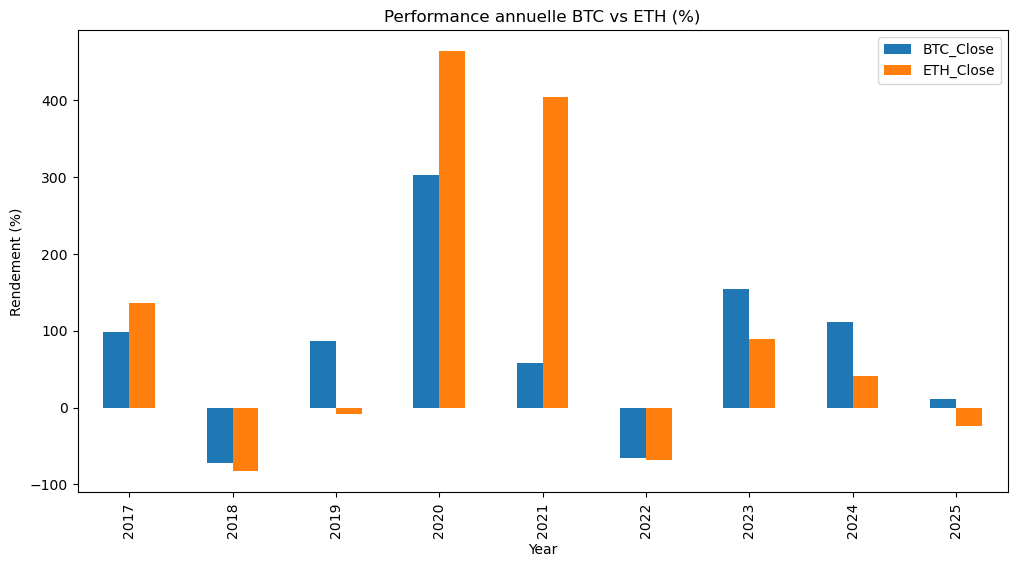

In [11]:
# On ajoute une colonne 'Year' pour regrouper par année
df['Year'] = df.index.year

# Calcul du rendement annuel en pourcentage
# (prix de fin d'année / prix de début d'année) - 1 → transformé en %
annual_return = df.groupby('Year')[['BTC_Close', 'ETH_Close']].apply(lambda x: (x.iloc[-1]/x.iloc[0]-1)*100)

# Affichage des performances sous forme de barplot
annual_return.plot(kind='bar', figsize=(12,6))
plt.title("Performance annuelle BTC vs ETH (%)")
plt.ylabel("Rendement (%)")
plt.show()

# Préparation pour Prophet (modèle de prévision)

In [12]:
# On remet l'index en colonne pour Prophet
btc_prophet = df.reset_index()[['Date', 'BTC_Close']]

# On renomme les colonnes pour qu'elles soient compatibles avec Prophet
btc_prophet = btc_prophet.rename(columns={'Date': 'ds', 'BTC_Close': 'y'})

# Vérification
print(btc_prophet.head())

          ds            y
0 2017-11-09  7143.580078
1 2017-11-10  6618.140137
2 2017-11-11  6357.600098
3 2017-11-12  5950.069824
4 2017-11-13  6559.490234


In [13]:
eth_prophet = df.reset_index()[['Date', 'ETH_Close']]
eth_prophet = eth_prophet.rename(columns={'Date': 'ds', 'ETH_Close': 'y'})

print(eth_prophet.head())

          ds           y
0 2017-11-09  320.884003
1 2017-11-10  299.252991
2 2017-11-11  314.681000
3 2017-11-12  307.907990
4 2017-11-13  316.716003


# Modélisation prédictive avec Prophet

15:30:19 - cmdstanpy - INFO - Chain [1] start processing
15:30:26 - cmdstanpy - INFO - Chain [1] done processing


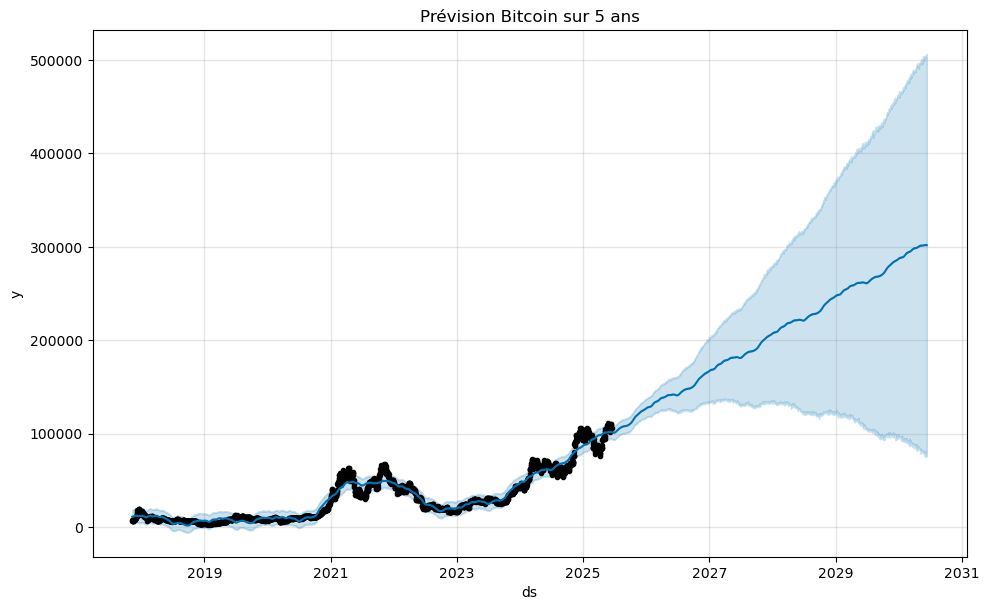

In [14]:
# Création et entraînement du modèle Prophet pour Bitcoin

model_btc = Prophet()
model_btc.fit(btc_prophet)

# Génération de la période de prévision (ici 5 ans supplémentaires)
future_btc = model_btc.make_future_dataframe(periods=5*365)

# Prédiction
forecast_btc = model_btc.predict(future_btc)

# Affichage des prévisions
model_btc.plot(forecast_btc)
plt.title("Prévision Bitcoin sur 5 ans")
plt.show()

15:30:28 - cmdstanpy - INFO - Chain [1] start processing
15:30:28 - cmdstanpy - INFO - Chain [1] done processing


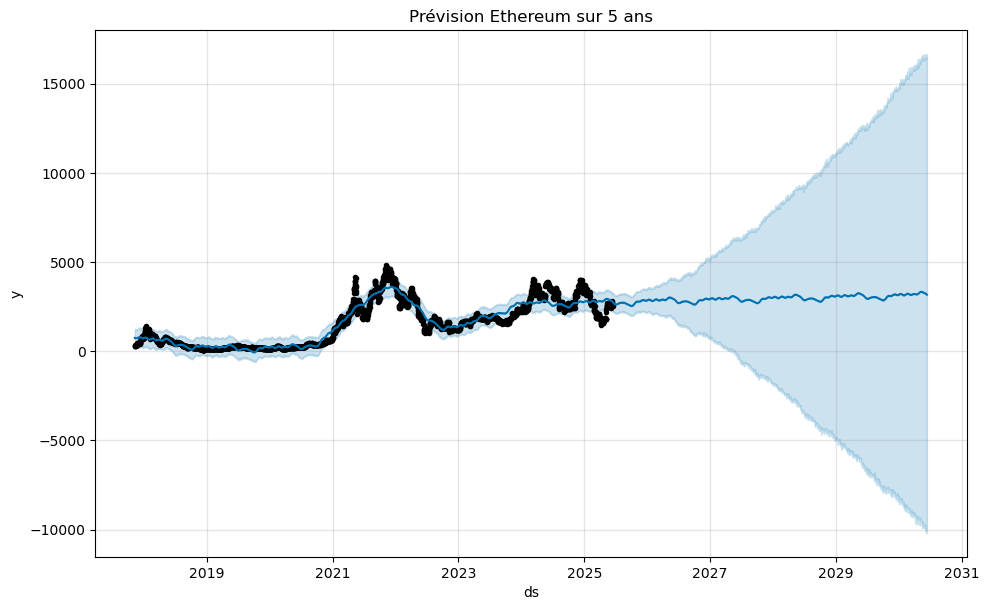

In [15]:
# Même processus pour Ethereum

model_eth = Prophet()
model_eth.fit(eth_prophet)

future_eth = model_eth.make_future_dataframe(periods=5*365)
forecast_eth = model_eth.predict(future_eth)

model_eth.plot(forecast_eth)
plt.title("Prévision Ethereum sur 5 ans")
plt.show()

# Conclusion

- Bitcoin et Ethereum présentent des croissances très fortes mais aussi de très fortes phases de correction.
- Leur volatilité reste extrêmement élevée.
- Prophet nous fournit des tendances mais reste un modèle simple basé uniquement sur l'historique des prix.